In [1]:
%pylab inline
import keras
import keras.backend as K
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from keras import Input, Model, Sequential
from keras.layers import Lambda, LSTM, RepeatVector, Dense, TimeDistributed, Bidirectional, concatenate,\
Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, Activation, Flatten, Reshape
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/home/ing-luca/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def split_data(dataset, timesteps):
    D = dataset.shape[1]
    if D < timesteps:
        return None
    elif D == timesteps:
        return dataset
    else:
        splitted_data, remaining_data = np.hsplit(dataset, [timesteps])
        remaining_data = split_data(remaining_data, timesteps)
        if remaining_data is not None:
            return np.vstack([splitted_data, remaining_data])
        return splitted_data

In [3]:
normalized_transactions_filepath = "../datasets/berka_dataset/usable/normalized_transactions.npy"

timesteps = 100
transactions = np.load(normalized_transactions_filepath)
transactions = split_data(transactions, timesteps)
transactions = transactions[np.std(transactions, 1) > float(1e-7)][:50000]
N, D = transactions.shape
print(transactions.shape)

(50000, 100)


In [41]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], 784))
x_train.shape

timesteps = 784
transactions = x_train / 255
transactions.shape

(60000, 784)

# Autoencoders

In [4]:
lr = 0.0001
epochs = 50
loss = 'mse'
latent_dim = 25
lstm_dim = 64
validation_split = 0.3
split_index = N-int(N*validation_split)
optimizer = 'adam'

indexes = np.random.choice(range(split_index, N), 16, replace=False)
early_stopping = EarlyStopping(monitor='loss', min_delta=0.00005, patience=10, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1, mode='auto', epsilon=0.0005, cooldown=0, min_lr=0)

In [5]:
def plot_predictions(autoencoder, indexes, data, reverse=False, add_timesteps=False):
    plt.subplots(4, 4, figsize=(15, 5))
    steps = np.reshape(np.arange(0, 1, 1/timesteps), (1, timesteps))
    print(steps.shape)
    
    for i, index in enumerate(indexes):
        plt.subplot(4, 4, i+1)
        plt.plot(data[index])
        if reverse:
            if add_timesteps:
                plt.plot((autoencoder.predict([data[index:index+1], steps]).T)[::-1])
            else:
                plt.plot((autoencoder.predict(data[index:index+1]).T)[::-1])
        else:
            if add_timesteps:
                plt.plot(autoencoder.predict([data[index:index+1], steps]).T)
            else:
                plt.plot(autoencoder.predict(data[index:index+1]).T)
        plt.xticks([])
        plt.yticks([])
        plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()
    
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.show()
    
def train_autoencoder(autoencoder, inputs, outputs):
    autoencoder.summary()
    history = autoencoder.fit(inputs, outputs, epochs=epochs, validation_split=validation_split, callbacks=[early_stopping, reduce_lr])
    return history

### Dense-Dense autoencoder

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               2600      
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
Total params: 25,325
Trainable params: 25,325
Non-trainable params: 0
_________________________________________________________________
Train on 35000 samples, validate on 15000 samples
Epoch 1/50
35000/35000 [==============================] - 3s 93us/step - loss: 0.0310 - val_loss: 0.0322
Epoch 2/50
35000/35000 [==============================] - 3s 91us/step - loss: 0.0258 - val_loss: 0.0319
Epoch 3/50

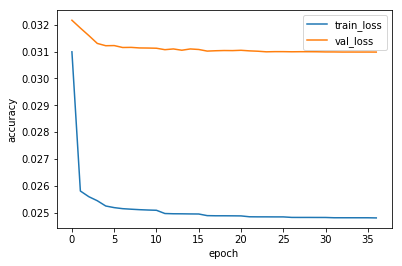

(1, 100)


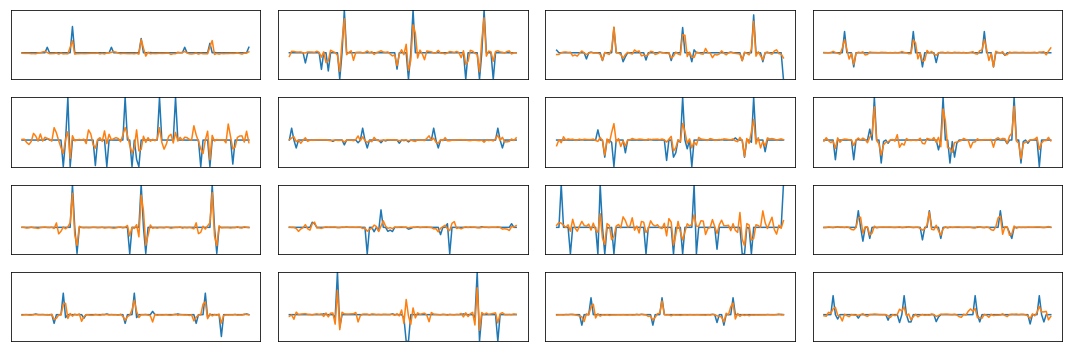

In [7]:
def get_dense_dense_autoencoder(timesteps, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Dense(timesteps, activation='tanh', input_shape=(timesteps,)))
    autoencoder.add(Dense(latent_dim, activation='tanh'))
    autoencoder.add(Dense(timesteps, activation='tanh'))
    autoencoder.add(Dense(timesteps, activation='tanh'))
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

dense_dense_autoencoder = get_dense_dense_autoencoder(timesteps, latent_dim, loss, lr)
history = train_autoencoder(dense_dense_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(dense_dense_autoencoder, indexes, transactions)

### LSTM-Dense autoencoder

In [20]:
def get_lstm_dense_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Lambda(lambda x: K.expand_dims(x), input_shape=(timesteps,)))
    autoencoder.add(LSTM(lstm_dim, return_sequences = False))
    autoencoder.add(Dense(latent_dim, activation='tanh'))
    autoencoder.add(Dense(timesteps, activation='tanh'))
    
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

lstm_dense_autoencoder = get_lstm_dense_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(lstm_dense_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(lstm_dense_autoencoder, indexes, transactions)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 784, 1)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_6 (Dense)              (None, 784)               8624      
Total params: 26,170
Trainable params: 26,170
Non-trainable params: 0
_________________________________________________________________
Train on 42000 samples, validate on 18000 samples
Epoch 1/10
 1088/42000 [..............................] - ETA: 13:28 - loss: 1.3377

KeyboardInterrupt: 

### Dense-LSTM autoencoder

In [ ]:
def get_dense_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Dense(latent_dim, activation='tanh', input_shape=(timesteps,)))
    autoencoder.add(RepeatVector(timesteps))
    autoencoder.add(LSTM(lstm_dim, return_sequences=True))
    autoencoder.add(TimeDistributed(Dense(1, activation='tanh')))
    autoencoder.add(Lambda(lambda x: K.squeeze(x, -1)))
    
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

dense_lstm_autoencoder = get_dense_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(dense_lstm_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(dense_lstm_autoencoder, indexes, transactions)

### LSTM-LSTM autoencoder

In [ ]:
def get_lstm_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Lambda(lambda x: K.expand_dims(x), input_shape=(timesteps,)))
    autoencoder.add(LSTM(lstm_dim, return_sequences = False))
    autoencoder.add(Dense(latent_dim, activation='tanh'))
    autoencoder.add(RepeatVector(timesteps))
    autoencoder.add(LSTM(lstm_dim, return_sequences=True))
    autoencoder.add(TimeDistributed(Dense(1, activation='tanh')))
    autoencoder.add(Lambda(lambda x: K.squeeze(x, -1)))
    
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

lstm_lstm_autoencoder = get_lstm_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(lstm_lstm_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(lstm_lstm_autoencoder, indexes, transactions)

### BLSTM-BLSTM autoencoder

In [9]:
def get_blstm_blstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr=0.001):
    model_inputs = Input((timesteps,))
    encoder = Lambda(lambda x: K.expand_dims(x))(model_inputs)

    encoder = Bidirectional(LSTM(lstm_dim, return_sequences = False))(encoder)
    encoder = Dense(latent_dim, activation='tanh')(encoder)
    encoder = RepeatVector(timesteps)(encoder)
    
    decoder = Bidirectional(LSTM(lstm_dim, return_sequences=True))(encoder)
    decoder = TimeDistributed(Dense(1, activation='tanh'))(decoder)
    decoder = Lambda(lambda x: K.squeeze(x, -1))(decoder)
    
    autoencoder = Model(model_inputs, decoder)

    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

steps = np.arange(0, 1, 1/timesteps)
steps = np.tile(steps,(transactions.shape[0],1))

blstm_blstm_autoencoder = get_blstm_blstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(blstm_blstm_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(blstm_blstm_autoencoder, indexes, transactions)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 100, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               33792     
_________________________________________________________________
dense_11 (Dense)             (None, 25)                3225      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 25)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          46080     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 1)            129       
__________

KeyboardInterrupt: 

### BLSTM-BLSTM autoencoder (with steps)

In [ ]:
def get_blstm_blstm_steps_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr=0.001):
    model_inputs = Input((timesteps,))
    encoder = Lambda(lambda x: K.expand_dims(x))(model_inputs)

    model_inputs_2 = Input((timesteps,))
    steps = Lambda(lambda x: K.expand_dims(x))(model_inputs_2)

    encoder = Bidirectional(LSTM(lstm_dim, return_sequences = False))(encoder)
    encoder = Dense(latent_dim, activation='tanh')(encoder)
    encoder = RepeatVector(timesteps)(encoder)
    encoder = concatenate([encoder, steps])
    
    decoder = Bidirectional(LSTM(lstm_dim, return_sequences=True))(encoder)
    decoder = TimeDistributed(Dense(1, activation='tanh'))(decoder)
    decoder = Lambda(lambda x: K.squeeze(x, -1))(decoder)
    
    autoencoder = Model([model_inputs, model_inputs_2], decoder)

    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

steps = np.arange(0, 1, 1/timesteps)
steps = np.tile(steps,(transactions.shape[0],1))

blstm_blstm_steps_autoencoder = get_blstm_blstm_steps_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(blstm_blstm_steps_autoencoder, [transactions, steps], transactions)
plot_history(history)
plot_predictions(blstm_blstm_steps_autoencoder, indexes, transactions, add_timesteps=True)

### Conv Conv autoencoder

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 100, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 32)            3104      
__________

35000/35000 [==============================] - 9s 258us/step - loss: 0.0230 - val_loss: 0.0293
Epoch 42/50
35000/35000 [==============================] - 9s 258us/step - loss: 0.0230 - val_loss: 0.0293
Epoch 43/50
35000/35000 [==============================] - 9s 264us/step - loss: 0.0229 - val_loss: 0.0293
Epoch 44/50
35000/35000 [==============================] - 9s 259us/step - loss: 0.0229 - val_loss: 0.0293
Epoch 45/50
35000/35000 [==============================] - 9s 264us/step - loss: 0.0229 - val_loss: 0.0292
Epoch 46/50
35000/35000 [==============================] - 9s 260us/step - loss: 0.0228 - val_loss: 0.0294

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 47/50
35000/35000 [==============================] - 9s 260us/step - loss: 0.0225 - val_loss: 0.0291
Epoch 48/50
35000/35000 [==============================] - 9s 260us/step - loss: 0.0225 - val_loss: 0.0290
Epoch 49/50
35000/35000 [==============================] - 9s 262us/step - 

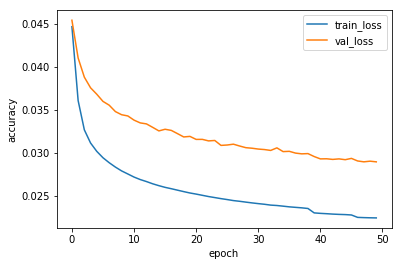

(1, 100)


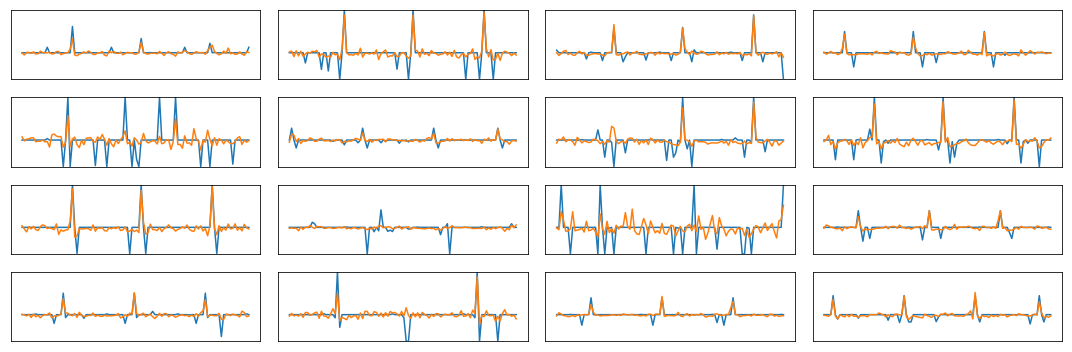

In [8]:
def get_conv_conv_autoencoder(timesteps, loss, lr):
    autoencoder_inputs = Input((timesteps, ))
    autoencoded = autoencoder_inputs

    autoencoded = Lambda(lambda x: K.expand_dims(x))(autoencoded)
    while autoencoded.shape[1] > 1:
        autoencoded = Conv1D(32, 3, activation='relu', padding='same')(autoencoded)
        autoencoded = MaxPooling1D(2, padding='same')(autoencoded)
    autoencoded = Flatten()(autoencoded)
    autoencoded = Dense(latent_dim, activation='tanh')(autoencoded)

    autoencoded = Lambda(lambda x: K.expand_dims(x))(autoencoded)
    while autoencoded.shape[1] < timesteps:
        autoencoded = Conv1D(32, 3, activation='relu', padding='same')(autoencoded)
        autoencoded = UpSampling1D(2)(autoencoded)
    autoencoded = Conv1D(1, 3, activation='relu', padding='same')(autoencoded)
    autoencoded = Lambda(lambda x: K.squeeze(x, -1))(autoencoded)
    autoencoded = Dense(timesteps, activation='tanh')(autoencoded)

    autoencoder = Model(autoencoder_inputs, autoencoded)
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

conv_conv_autoencoder = get_conv_conv_autoencoder(timesteps, loss, lr)
history = train_autoencoder(conv_conv_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(conv_conv_autoencoder, indexes, transactions)